# CMIP6 Temperature Analysis

In [3]:
%pylab inline
import os
import pandas as pd
import xarray as xr
import cftime
import pickle

import cartopy.crs as ccrs
import cartopy.feature as cfeature

plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina' 

Populating the interactive namespace from numpy and matplotlib


In [2]:
import fsspec
from tqdm.notebook import tqdm

In [3]:
import dask
from dask.distributed import Client

client = Client()  # set up local cluster on your laptop

client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 48,Total memory: 187.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33069,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 48
Started: Just now,Total memory: 187.00 GiB
Comm: tcp://127.0.0.1:34771,Total threads: 6
Dashboard: http://127.0.0.1:44507/status,Memory: 23.38 GiB
Nanny: tcp://127.0.0.1:37681,


### Load Data Catalog

In [4]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 523774 entries, 0 to 523773
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   activity_id     523774 non-null  object 
 1   institution_id  523774 non-null  object 
 2   source_id       523774 non-null  object 
 3   experiment_id   523774 non-null  object 
 4   member_id       523774 non-null  object 
 5   table_id        523774 non-null  object 
 6   variable_id     523774 non-null  object 
 7   grid_label      523774 non-null  object 
 8   zstore          523774 non-null  object 
 9   dcpp_init_year  141466 non-null  float64
 10  version         523774 non-null  int64  
dtypes: float64(1), int64(1), object(9)
memory usage: 44.0+ MB


In [5]:
## find the runs we're interested in
df_tas = df[(df.table_id == 'Amon') & (df.variable_id == 'tas')]
len(df_tas)

15492

In [6]:
run_counts = df_tas.groupby(['source_id', 'experiment_id'])['zstore'].count()
run_counts

source_id    experiment_id
ACCESS-CM2   1pctCO2           1
             abrupt-4xCO2      1
             hist-nat          3
             historical        5
             piClim-4xCO2      1
                              ..
UKESM1-0-LL  ssp245           17
             ssp370           16
             ssp434            5
             ssp534-over       5
             ssp585            5
Name: zstore, Length: 983, dtype: int64

In [7]:
source_ids = []
experiment_ids = ['historical', 'ssp585']
for name, group in df_tas.groupby('source_id'):
    if all([expt in group.experiment_id.values
            for expt in experiment_ids]):
        source_ids.append(name)
source_ids

['ACCESS-CM2',
 'ACCESS-ESM1-5',
 'AWI-CM-1-1-MR',
 'BCC-CSM2-MR',
 'CAMS-CSM1-0',
 'CAS-ESM2-0',
 'CESM2',
 'CESM2-WACCM',
 'CIESM',
 'CMCC-CM2-SR5',
 'CMCC-ESM2',
 'CNRM-CM6-1',
 'CNRM-CM6-1-HR',
 'CNRM-ESM2-1',
 'CanESM5',
 'CanESM5-CanOE',
 'E3SM-1-1',
 'EC-Earth3',
 'EC-Earth3-CC',
 'EC-Earth3-Veg',
 'EC-Earth3-Veg-LR',
 'FGOALS-f3-L',
 'FGOALS-g3',
 'FIO-ESM-2-0',
 'GFDL-CM4',
 'GFDL-ESM4',
 'GISS-E2-1-G',
 'GISS-E2-1-H',
 'HadGEM3-GC31-LL',
 'HadGEM3-GC31-MM',
 'IITM-ESM',
 'INM-CM4-8',
 'INM-CM5-0',
 'IPSL-CM6A-LR',
 'KACE-1-0-G',
 'KIOST-ESM',
 'MCM-UA-1-0',
 'MIROC-ES2L',
 'MIROC6',
 'MPI-ESM1-2-HR',
 'MPI-ESM1-2-LR',
 'MRI-ESM2-0',
 'NESM3',
 'NorESM2-LM',
 'NorESM2-MM',
 'TaiESM1',
 'UKESM1-0-LL']

In [8]:
def load_data(source_id, expt_id):
    """
    Load data for given source and expt ids
    """
    uri_list = df_tas[(df_tas.source_id == source_id) &
                         (df_tas.experiment_id == expt_id)].zstore.values
    
    ds = [fixdims(xr.open_zarr(fsspec.get_mapper(uri, token='anon'), consolidated=True).tas) \
          for uri in uri_list]
    
    ds = ds[0] # take first ensemble member
    
    return ds

In [4]:
## functions for global avg. and anomaly calculation
def gavg(idata):
    """calculate global average
    e.g., x1=gavg(d1['t2m'])"""

    try:
        wgt1=np.cos(np.deg2rad(idata.lat))*(idata*0+1)
        ga=(wgt1*idata).sum(dim=['lat','lon'])/wgt1.sum(dim=['lat','lon'])
        return ga
    except AttributeError:
        print('Attribute error')
        return idata
    
def anomaly(idata):
    """calculate anomaly"""

    clim=idata.groupby('time.month').mean(dim='time')
    anom=idata.groupby('time.month')-clim

    return anom

def fixdims(var):
    """changes the dimensions to lat, lon, and level"""

    for ii in var.dims:
        kk=ii[:3].lower()

        if kk == 'lat':
            var=var.rename({ii:'lat'})

        if kk == 'lon':
            var=var.rename({ii:'lon'})

        if kk == 'lev' or kk == 'ple' or kk == 'pre':
            var=var.rename({ii:'level'})

        if kk == 'tim':
            var=var.rename({ii:'time'})

    return var

In [5]:
import warnings

# Turn off future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [6]:
season = 'JJA'  # this determines which season to analyze

In [17]:
import dask
import dask.array as da
import xarray as xr
import pandas as pd
from tqdm import tqdm

@dask.delayed
def process_source(source_id):
    try:
        ds_hist = load_data(source_id, 'historical').sel(time=slice('1960', None))
        ds_ssp = load_data(source_id, 'ssp585').sel(time=slice(None, '2025'))
    except:
        return None

    x1 = xr.concat([ds_hist, ds_ssp], dim='time')
    x1['time'] = pd.date_range('1960-01-01', freq='ME', periods=len(x1.time))
    x1 = x1.sel(time=x1['time.season'] == season)  # get particular season

    if 'height' in x1.coords:
        x1 = x1.drop_vars('height')
        
    print(source_id, x1.shape)
    return x1

results = []
for source_id in tqdm(source_ids):
    result = process_source(source_id)
    results.append(result)

    
# Compute all results in parallel
results = dask.compute(*results)
results = [[res,mn] for res,mn in zip(results,source_ids) if res is not None]  # filter out None results

## set 'results' to be the model fields and 'mod_names' to be the name of the model
results1 = [ii[0] for ii in results]
mod_names = [ii[1] for ii in results]
results = results1

  0%|          | 0/47 [00:00<?, ?it/s]

100%|██████████| 47/47 [00:00<00:00, 30981.03it/s]

/usr/local/lib/python3.12/dist-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/lib/python3.12/dist-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


/usr/local/lib/python3.12/dist-packages/xarray/core/indexing.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(self.get_duck_array(), dtype=dtype)


/usr/local/lib/python3.12/dist-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/lib/python3.12/dist-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


/usr/local/lib/python3.12/dist-packages/xarray/core/indexing.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(self.get_duck_array(), dtype=dtype)
/usr/local/lib/python3.12/dist-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


/usr/local/lib/python3.12/dist-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/lib/python3.12/dist-packages/xarray/core/indexing.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(self.get_duck_array(), dtype=dtype)


/usr/local/lib/python3.12/dist-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/lib/python3.12/dist-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


/usr/local/lib/python3.12/dist-packages/xarray/core/indexing.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(self.get_duck_array(), dtype=dtype)
/usr/local/lib/python3.12/dist-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


/usr/local/lib/python3.12/dist-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


/usr/local/lib/python3.12/dist-packages/xarray/core/indexing.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(self.get_duck_array(), dtype=dtype)
/usr/local/lib/python3.12/dist-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


/usr/local/lib/python3.12/dist-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/lib/python3.12/dist-packages/xarray/core/indexing.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(self.get_duck_array(), dtype=dtype)


/usr/local/lib/python3.12/dist-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/lib/python3.12/dist-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


/usr/local/lib/python3.12/dist-packages/xarray/core/indexing.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(self.get_duck_array(), dtype=dtype)
/usr/local/lib/python3.12/dist-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


/usr/local/lib/python3.12/dist-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


/usr/local/lib/python3.12/dist-packages/xarray/core/indexing.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(self.get_duck_array(), dtype=dtype)
/usr/local/lib/python3.12/dist-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


/usr/local/lib/python3.12/dist-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/lib/python3.12/dist-packages/xarray/core/indexing.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(self.get_duck_array(), dtype=dtype)


/usr/local/lib/python3.12/dist-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/lib/python3.12/dist-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


/usr/local/lib/python3.12/dist-packages/xarray/core/indexing.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(self.get_duck_array(), dtype=dtype)


/usr/local/lib/python3.12/dist-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/lib/python3.12/dist-packages/xarray/coding/times.py:992: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


/usr/local/lib/python3.12/dist-packages/xarray/core/indexing.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(self.get_duck_array(), dtype=dtype)


In [4]:
## download data
# !wget https://data.giss.nasa.gov/pub/gistemp/gistemp1200_GHCNv4_ERSSTv5.nc.gz
# !gunzip gistemp1200_GHCNv4_ERSSTv5.nc.gz

--2024-08-07 16:08:24--  https://data.giss.nasa.gov/pub/gistemp/gistemp1200_GHCNv4_ERSSTv5.nc.gz


Resolving data.giss.nasa.gov (data.giss.nasa.gov)... 

129.164.128.233, 2001:4d0:2310:230::233
Connecting to data.giss.nasa.gov (data.giss.nasa.gov)|129.164.128.233|:443... 

connected.


HTTP request sent, awaiting response... 

200 OK
Length: 25450069 (24M) [application/x-gzip]
Saving to: ‘gistemp1200_GHCNv4_ERSSTv5.nc.gz’

          gistemp12   0%[                    ]       0  --.-KB/s               

         gistemp120   2%[                    ] 704.00K  2.86MB/s               

        gistemp1200  15%[==>                 ]   3.78M  8.17MB/s               

       gistemp1200_  25%[====>               ]   6.19M  9.23MB/s               

      gistemp1200_G  34%[=====>              ]   8.31M  9.48MB/s               

     gistemp1200_GH  43%[=======>            ]  10.47M  9.66MB/s               

    gistemp1200_GHC  52%[=========>          ]  12.69M  9.83MB/s               

   gistemp1200_GHCN  61%[===========>        ]  14.94M  9.98MB/s               

  gistemp1200_GHCNv  71%[=============>      ]  17.23M  10.1MB/s               

 gistemp1200_GHCNv4  80%[===============>    ]  19.55M  10.2MB/s               

gistemp1200_GHCNv4_  90%[=================>  ]  21.88M  10.3MB/s               

gistemp1200_GHCNv4_ 100%[===================>]  24.27M  10.5MB/s    in 2.3s    

2024-08-07 16:08:27 (10.5 MB/s) - ‘gistemp1200_GHCNv4_ERSSTv5.nc.gz’ saved [25450069/25450069]



rm: cannot remove 'gistemp1200_GHCNv4_ERSSTv5.nc.gz': No such file or directory


In [7]:
## read GISTEMP data
## 1970-1976 to 2018-2023
giss = xr.open_dataset('gistemp1200_GHCNv4_ERSSTv5.nc').tempanomaly
giss = giss.sel(time = giss['time.season'] == season)

In [8]:
## calculate difference in periods
giss = giss.sel(time=slice('2018', '2023')).mean(dim='time') - giss.sel(time=slice('1970','1976')).\
          mean(dim='time')

## change longitudes to 0-360
x1 = len(giss.lon)//2
lon = giss.lon
lat = giss.lat
lon=np.concatenate( (lon[x1:],lon[0:x1]+360) )
array3d=np.concatenate( (giss.values[:,x1:],giss.values[:,0:x1]), axis=1 )
giss = xr.DataArray(array3d, dims = 'lat lon'.split(), coords = {'lat': lat, 'lon': lon})

In [20]:
## this regrids the models to the giss grid
## combines into a single xarray
gridded_diff = []
for ii in results:
    if max(ii.lat) > 200: continue
    ## select time period of interest and do simple regridding to Berkeley Earth grid
    x1 = (ii.sel(time=slice('2018', '2023')).mean(dim='time') - ii.sel(time=slice('1970','1976')).\
          mean(dim='time')).interp(lat = giss.lat, lon = giss.lon)
    gridded_diff.append(x1)
    print('I',end='')

gridded = xr.concat(gridded_diff, dim='model')#.mean(dim='model')
gridded['model'] = mod_names
gridded.load();

IIII

IIII

IIII

IIIII

III

IIIII

IIII

IIIII

IIIII

IIII

III

In [21]:
gridded.to_netcdf('gridded_models.nc')

In [9]:
gridded = xr.open_dataset('gridded_models.nc').tas
gridded

<xarray.DataArray 'tas' (model: 46, lat: 90, lon: 180)>
[745200 values with dtype=float64]
Coordinates:
  * lat      (lat) float32 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float32 1.0 3.0 5.0 7.0 9.0 ... 351.0 353.0 355.0 357.0 359.0
  * model    (model) object 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'

In [10]:
diff = giss - gridded.mean(dim = 'model')
float(gavg(diff))

-0.1140562446878044

the cell above should generate a value of -0.114

In [24]:
# Assuming 'models' and 'giss' are your datasets
min_model = gridded.min(dim='model')
max_model = gridded.max(dim='model')

mask = xr.where((giss >= min_model) & (giss <= max_model), 1, 0)

Text(0, 0.5, 'Latitude')

/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


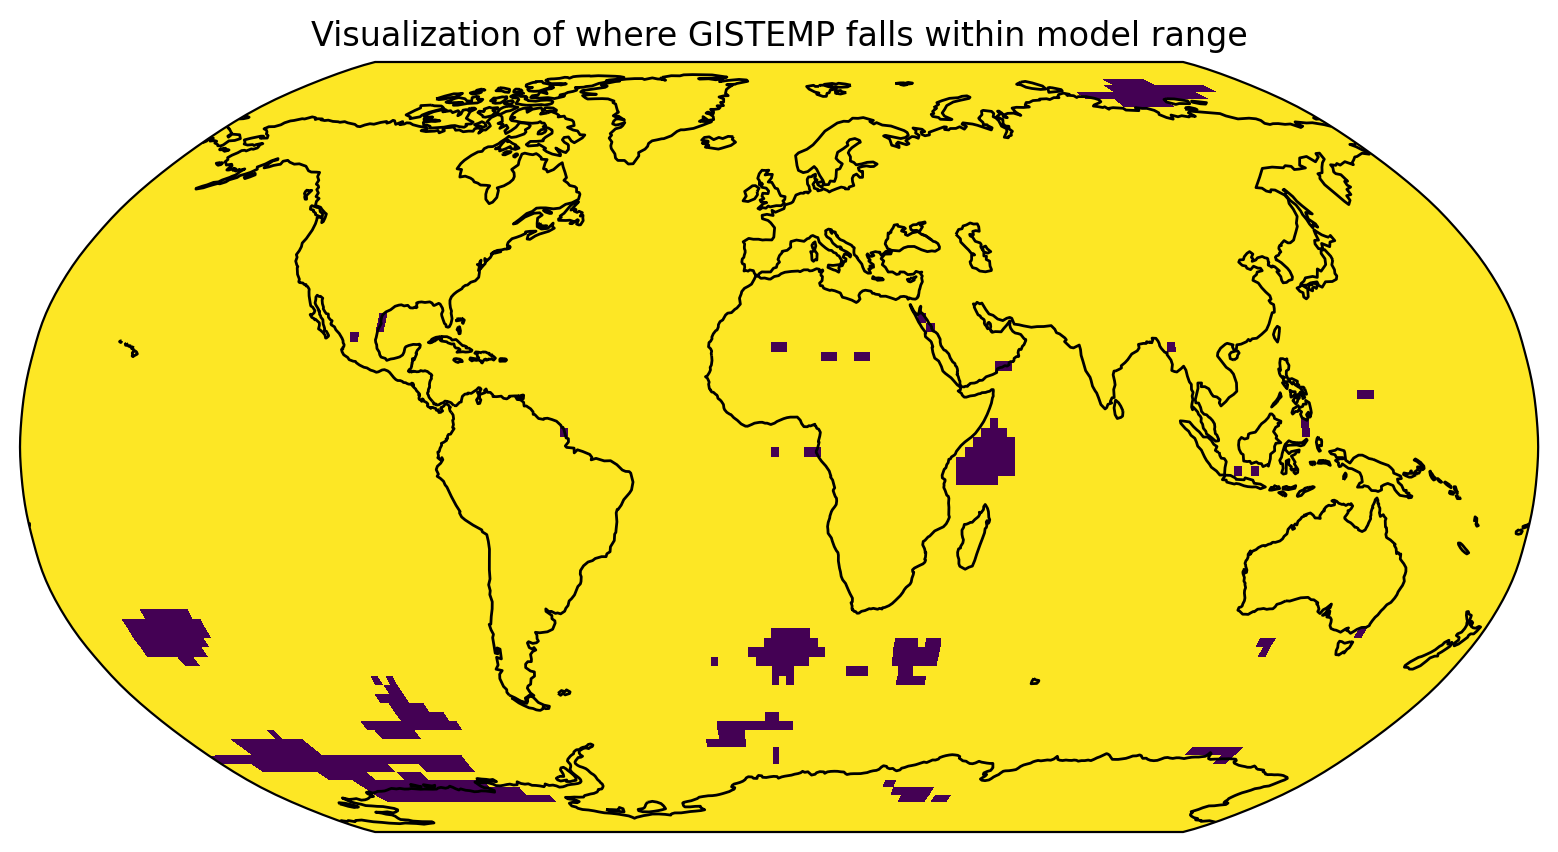

In [25]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.LAND, facecolor='lightgray')

# Ensure the mask aligns with the lat/lon coordinates
lon = mask.lon
lat = mask.lat

# Plotting the mask; specify extent=[lon.min(), lon.max(), lat.min(), lat.max()]
mask.plot(ax=ax, transform=ccrs.PlateCarree(), x='lon', y='lat', add_colorbar=False, cmap='viridis')

plt.title('Visualization of where GISTEMP falls within model range')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

#savefig('giss_comp.jpg',dpi=300)

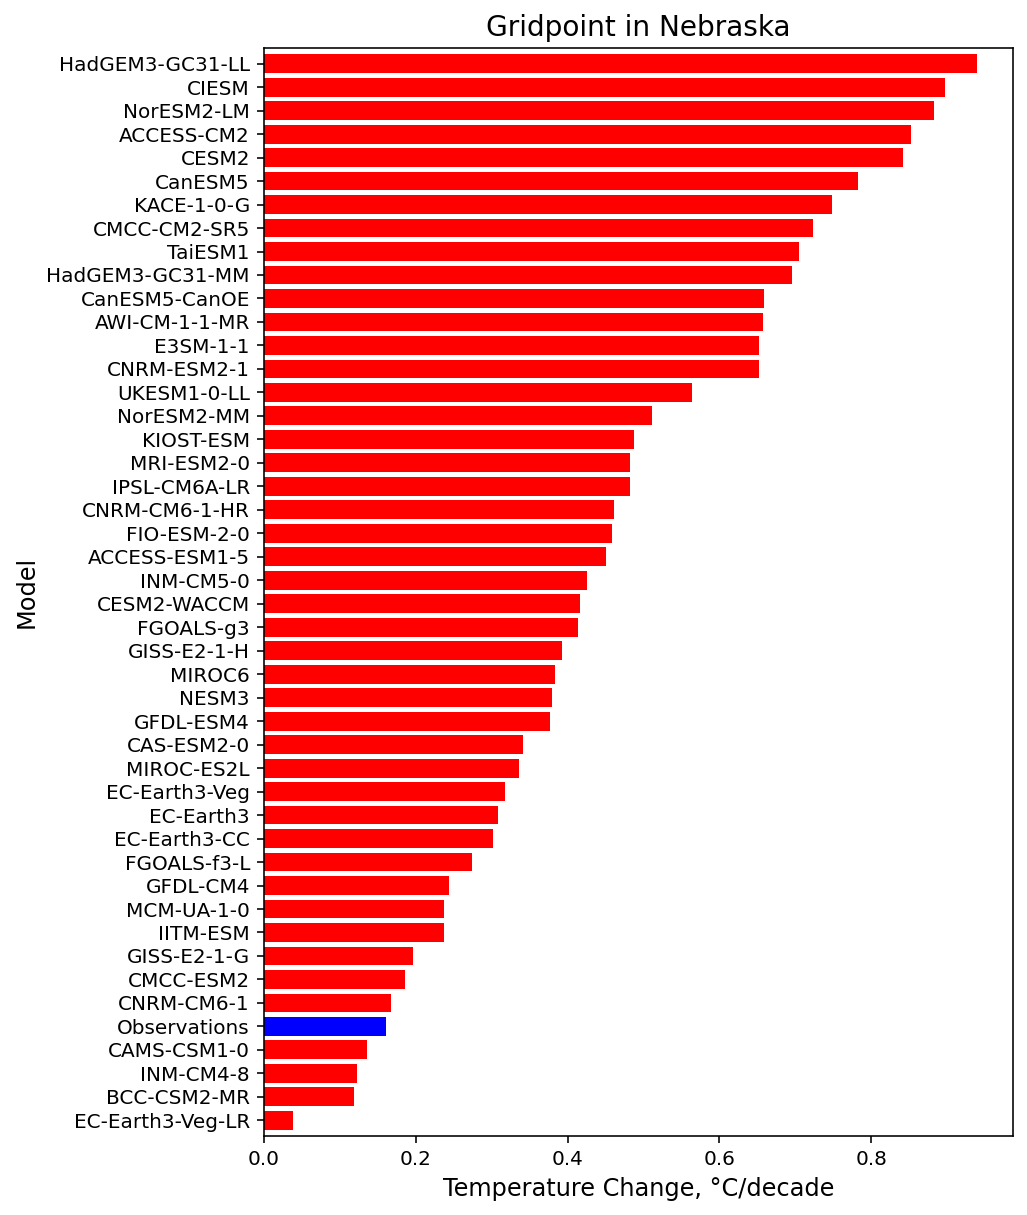

In [12]:
# Assuming gridded_diff is your DataArray, convert it to a Pandas DataFrame for easier manipulation
df = gridded.sel(lat=42, lon=360-93.5, method='nearest').to_dataframe().reset_index()

# Remove NaNs
df_clean = df.dropna()

# Insert the observed value as a new row at the end of the DataFrame
observed_value = giss.sel(lat=42, lon=360-93.5, method='nearest').values
df_observed = pd.DataFrame({'model': ['Observations'], 'tas': [observed_value]})
df_sorted = pd.concat([df_clean, df_observed], ignore_index=True)
df_sorted['color'] = ['red']*(len(df_sorted)-1) + ['blue']
df_sorted['tas'] = df_sorted.tas.astype(float)
df_sorted['tas'] /= 4.7
df_sorted = df_sorted.sort_values(by='tas').reset_index(drop=True)

# Plot the data as horizontal bars
plt.figure(figsize=(8, 10))
plt.subplots_adjust(left=0.25)

# Plot all bars, using brown for models and blue for observations
df_sorted['tas'].plot.barh(color=df_sorted.color, width=0.8)

# Customize the plot
plt.title('Gridpoint in Nebraska', fontsize=14)
plt.ylabel('Model', fontsize=12)
plt.xlabel('Temperature Change, °C/decade', fontsize=12)

# Adjust y-axis labels to match the order and style of the example plot
plt.yticks(np.arange(len(df_sorted)), df_sorted['model'], fontsize=10);

# Optionally, save the plot to a file
# plt.savefig('nebraska.jpg', dpi=300)

In [70]:
## models in spencer's figure
spencer_models = [    "CIESM",     "HadGEM3-GC31-LL",    "CESM2-WACCM",    "CESM2",    "CanESM5",
                  "UKESM1-0-LL",    "CanESM5-CanOE",    "EC-Earth3-Veg",    "ACCESS-ESM1-5",    "CMCC-CM2-SR5",    
                  "KACE-1-0-G",    "NESM3",    "MRI-ESM2-0",    "AWI-CM-1-1-MR",    "NorESM2-LM",    "NorESM2-MM",
                  "IPSL-CM6A-LR",    "MCM-UA-1-0",    "ACCESS-CM2",    "EC-Earth3",    "CNRM-CM6-1-HR",
                  "CNRM-ESM2-1",    "MIROC6",    "FGOALS-f3-L",    "BCC-CSM2-MR",    "FGOALS-g3",    "GFDL-ESM4",
                  "MPI-ESMI-2-HR",    "FIO-ESM-2-0",    "INM-CM4-8",    "GISS-E2-1-G",    "MIROC-ES2L",
                  "CAMS-CSM1-0",    "MPI-ESMI-2-LR",    "CNRM-CM6-1",    "INM-CM5-0"]
## set(spencer_models) - set(mod_names)
## set(mod_names) - set(spencer_models)

In [13]:
# compare means
mean_model = gridded.mean(dim='model')
mask = xr.where((giss >= mean_model), 1, 0)

print(f'area fraction where obs. are hotter: {float(gavg(mask)):.2f}')

area fraction where obs. are hotter: 0.40


In [14]:
## read Mark Zelinka's table of model ECS
import requests
import json

# URL of the raw JSON file
url = "https://raw.githubusercontent.com/mzelinka/cmip56_forcing_feedback_ecs/master/cmip56_forcing_feedback_ecs.json"

# Fetch the content from the URL
response = requests.get(url)
ecs = json.loads(response.text)

In [15]:
## remove models if ECS is below 2 or above 4
## or if there is no ECS value for the model
## 'filter' contains the filtered, gridded models
filter = gridded.copy()
for ii in gridded.model.values:
    try:
        ecsx = ecs['CMIP6'][ii]['r1i1p1f1']['ECS']
        if ecsx > 2 and ecsx < 4: continue
    except:
        pass
        ecsx = -1
    print('removing',ii,ecsx)
    filter = filter[filter.model != ii]

removing ACCESS-CM2 4.66200640987198
removing CAS-ESM2-0 -1
removing CESM2 5.147915202979365
removing CESM2-WACCM 4.684285678187821
removing CIESM 5.632439077197677
removing CNRM-CM6-1 -1
removing CNRM-CM6-1-HR -1
removing CNRM-ESM2-1 -1
removing CanESM5 5.638903077035479
removing CanESM5-CanOE -1
removing E3SM-1-1 -1
removing EC-Earth3 -1
removing EC-Earth3-CC 4.230871276276654
removing EC-Earth3-Veg 4.331213011183422
removing EC-Earth3-Veg-LR 4.231888886346553
removing FIO-ESM-2-0 -1
removing HadGEM3-GC31-LL -1
removing HadGEM3-GC31-MM -1
removing INM-CM4-8 1.8271399573607425
removing INM-CM5-0 1.9158220047671057
removing IPSL-CM6A-LR 4.699160878253567
removing KACE-1-0-G 4.749146322262604
removing KIOST-ESM -1
removing MCM-UA-1-0 -1
removing MIROC-ES2L -1
removing NESM3 4.764447107393327
removing TaiESM1 4.35549010691132
removing UKESM1-0-LL -1


In [16]:
mean_model = filter.mean(dim='model')
mask = xr.where((giss >= mean_model), 1, 0)

print(f'area fraction where obs. are hotter: {float(gavg(mask)):.2f}')

area fraction where obs. are hotter: 0.53


Text(0.5, 1.0, 'model mean minus observation')

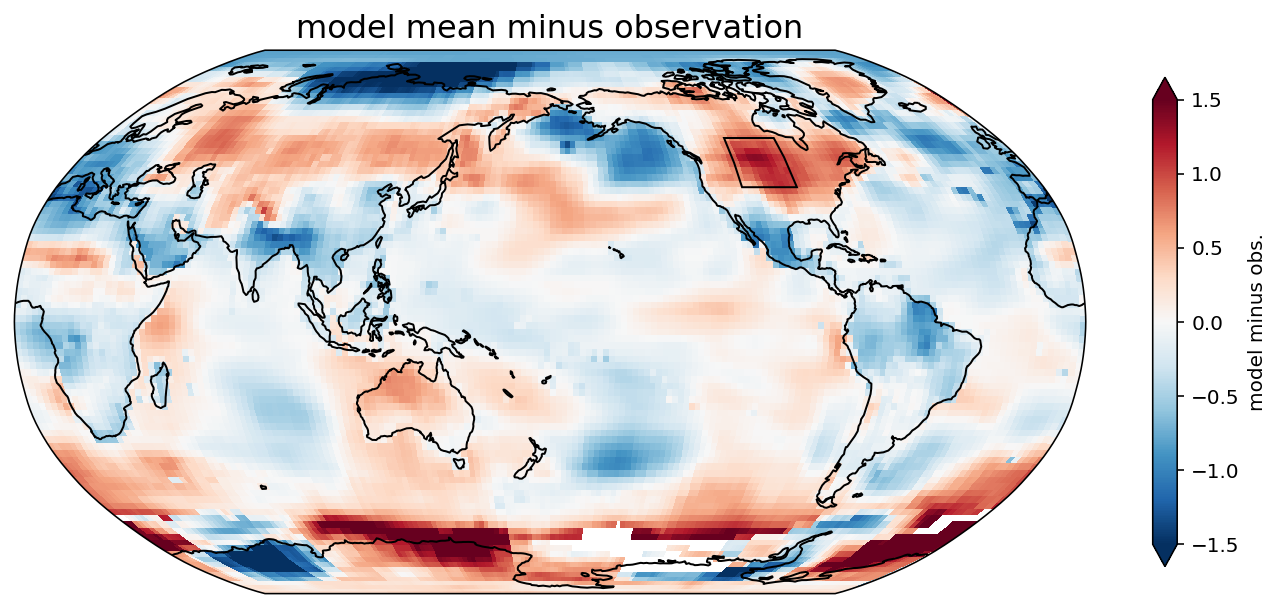

In [17]:
## make a map of models minus obs.
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))

# Add features
ax.add_feature(cfeature.COASTLINE)
# ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot the data
(filter.mean(dim='model')-giss).plot(ax=ax, transform=ccrs.PlateCarree(), \
                  cmap='RdBu_r', cbar_kwargs={'orientation': 'vertical', 'pad': 0.05, 'shrink': 0.75,\
                                             'label': 'model minus obs.'}, vmin = -1.5, vmax = 1.5)

## put a box around central US
lon_start, lon_end = -110, -90
lat_start, lat_end = 40, 55
rect = Rectangle(
    (lon_start, lat_start),  # Bottom left corner
    lon_end - lon_start,     # Width (lon range)
    lat_end - lat_start,     # Height (lat range)
    linewidth=1,
    edgecolor='black',
    facecolor='none',
    transform=ccrs.PlateCarree()
)
ax.add_patch(rect)

# Set the title
ax.set_title('model mean minus observation', fontsize = 16)

# savefig('diff_plot.jpg', dpi = 300)

### old stuff

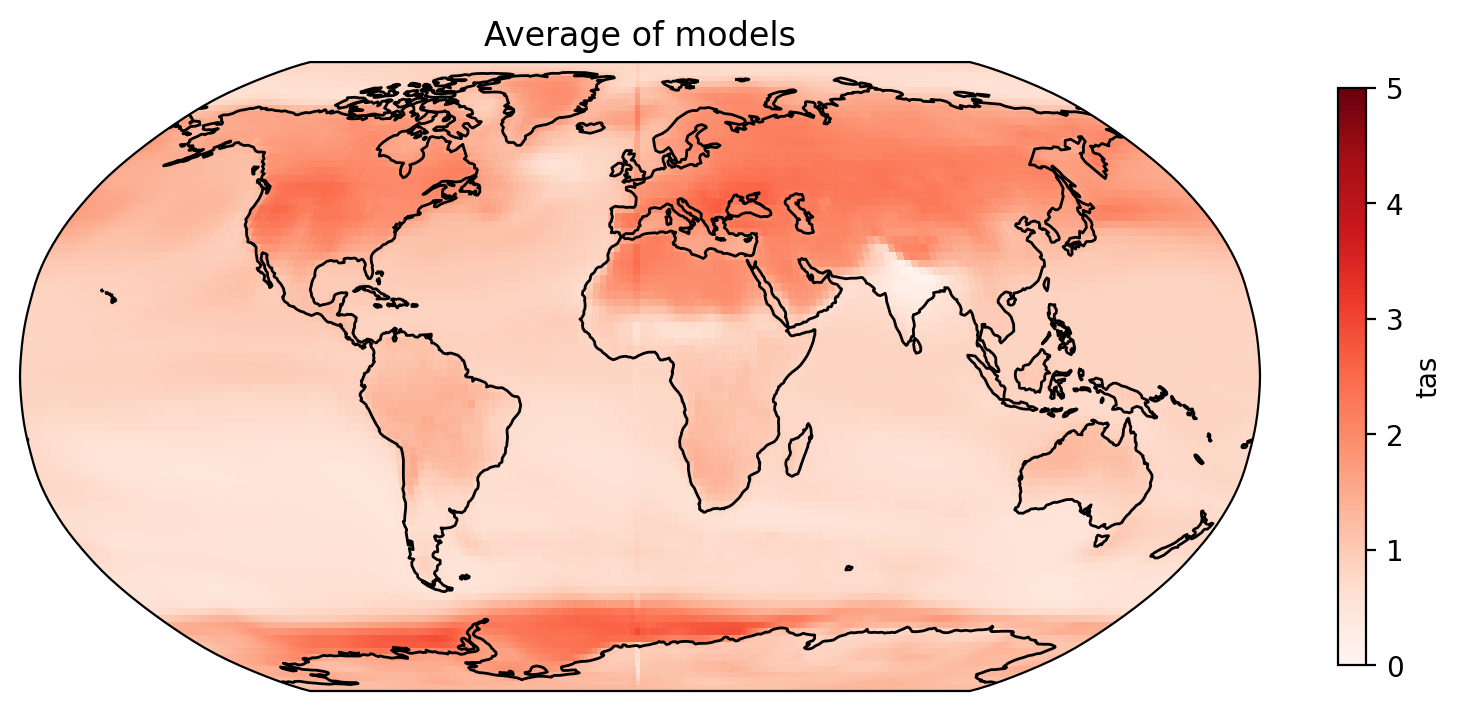

In [19]:
# Select a specific slice of the combined data to plot (for example, the first slice)
data_to_plot = gridded_diff.mean(dim='model')

# Plot using cartopy with Robinson projection
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.Robinson())

# Add features
ax.add_feature(cfeature.COASTLINE)
# ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot the data
data_to_plot.plot(ax=ax, transform=ccrs.PlateCarree(), \
                  cmap='Reds', cbar_kwargs={'orientation': 'vertical', 'pad': 0.05, 'shrink': 0.75}, vmin = 0, vmax = 5)

# Set the title
ax.set_title('Average of models')

# Show the plot
plt.show()


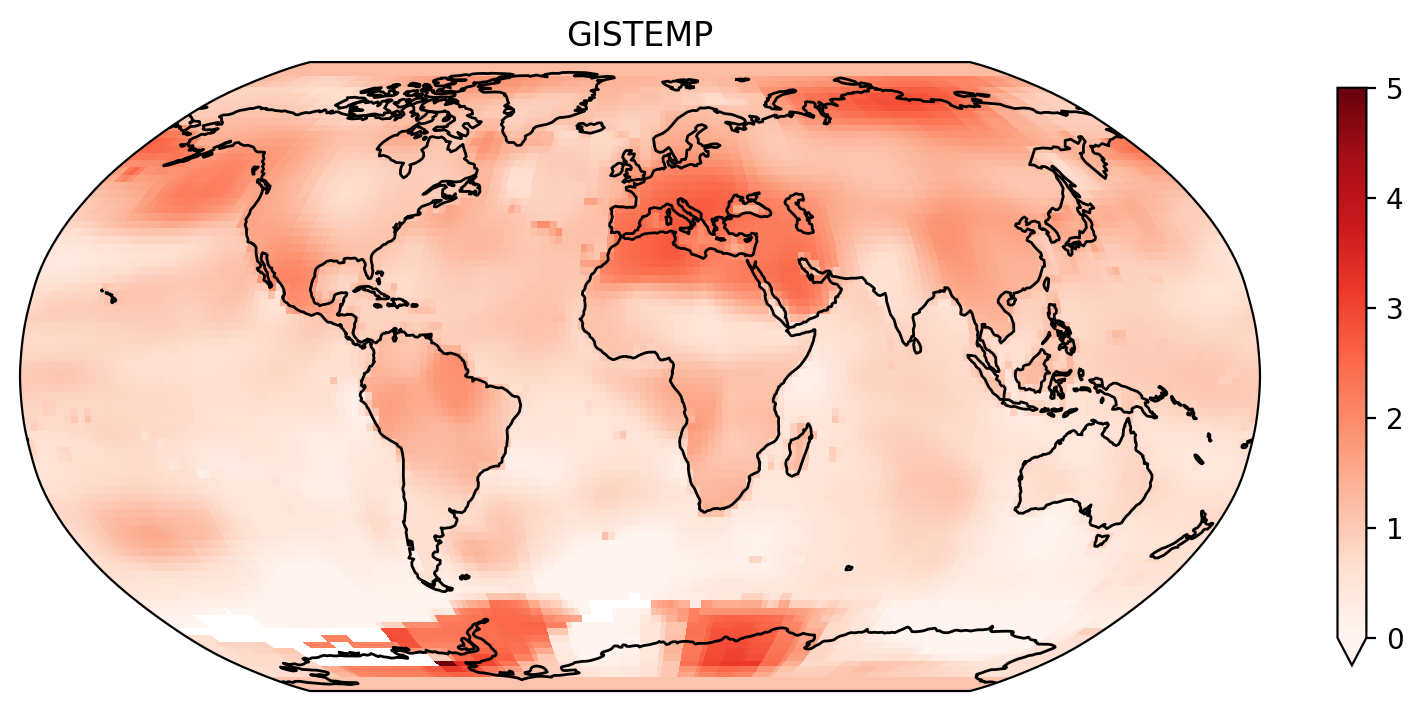

In [20]:
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.Robinson())

# Add features
ax.add_feature(cfeature.COASTLINE)
#ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot the data
giss.plot(ax=ax, transform=ccrs.PlateCarree(), \
                  cmap='Reds', cbar_kwargs={'orientation': 'vertical', 'pad': 0.05, 'shrink': 0.75}, vmin = 0, vmax = 5)

# Set the title
ax.set_title('GISTEMP')

# Show the plot
plt.show()

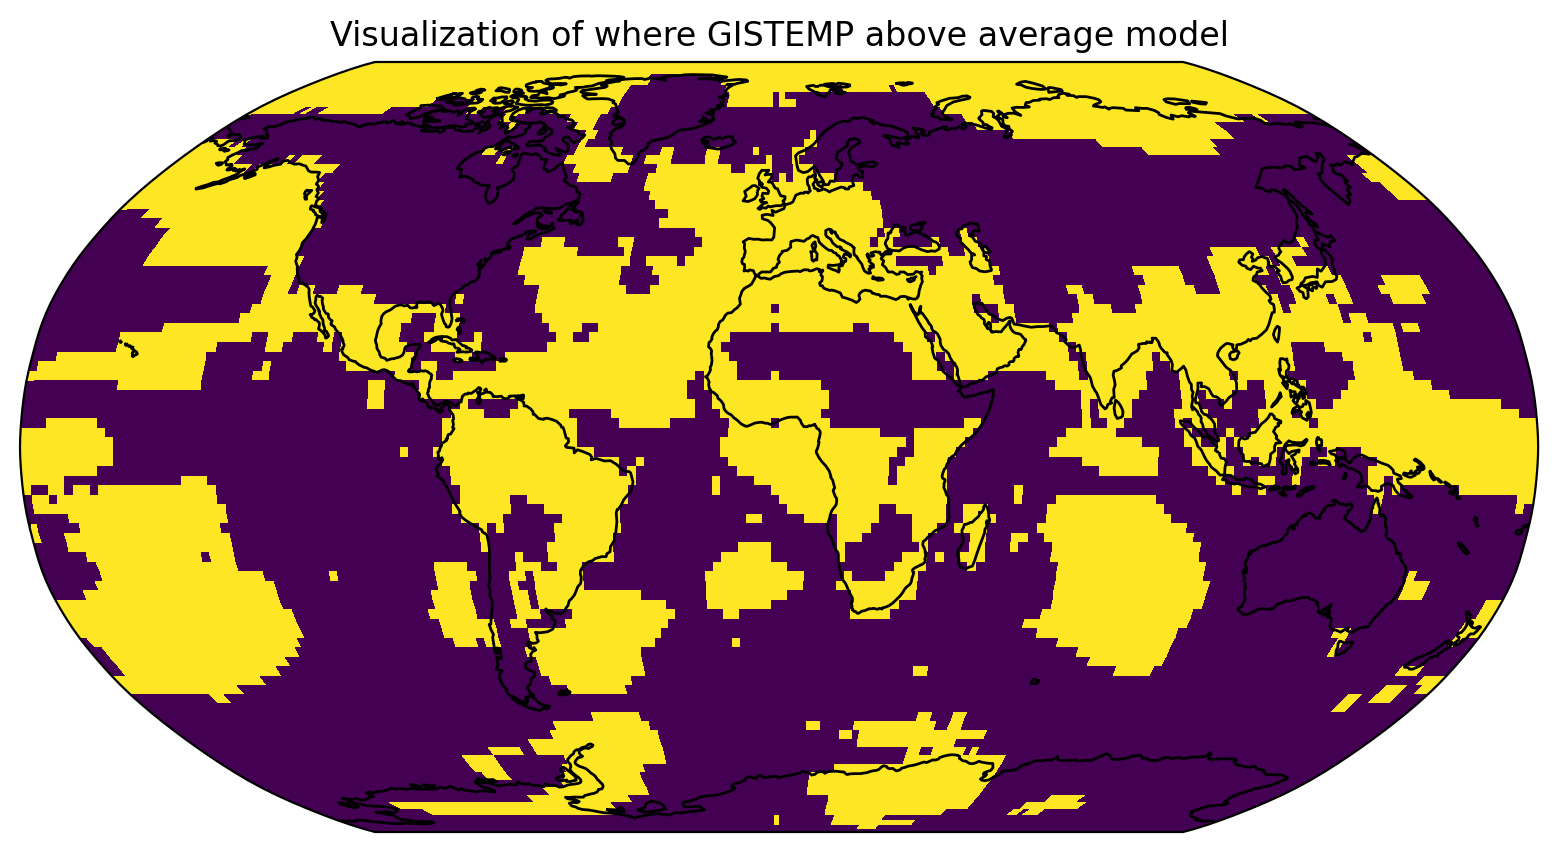

In [41]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.LAND, facecolor='lightgray')

# Ensure the mask aligns with the lat/lon coordinates
lon = mask.lon
lat = mask.lat

# Plotting the mask; specify extent=[lon.min(), lon.max(), lat.min(), lat.max()]
mask.plot(ax=ax, transform=ccrs.PlateCarree(), x='lon', y='lat', add_colorbar=False, cmap='viridis')

plt.title('Visualization of where GISTEMP above average model')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

#savefig('giss_mean.jpg',dpi=300)